In [3]:
from demohelpers import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from trustyai.model import Model, feature, output, feature_domain
from trustyai.explainers import CounterfactualExplainer, LimeExplainer, SHAPExplainer

import warnings
import xgboost

warnings.filterwarnings('ignore')
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Toy example
We'll create a toy dataset with 4 well defined clusters, one per quadrant of the plot:

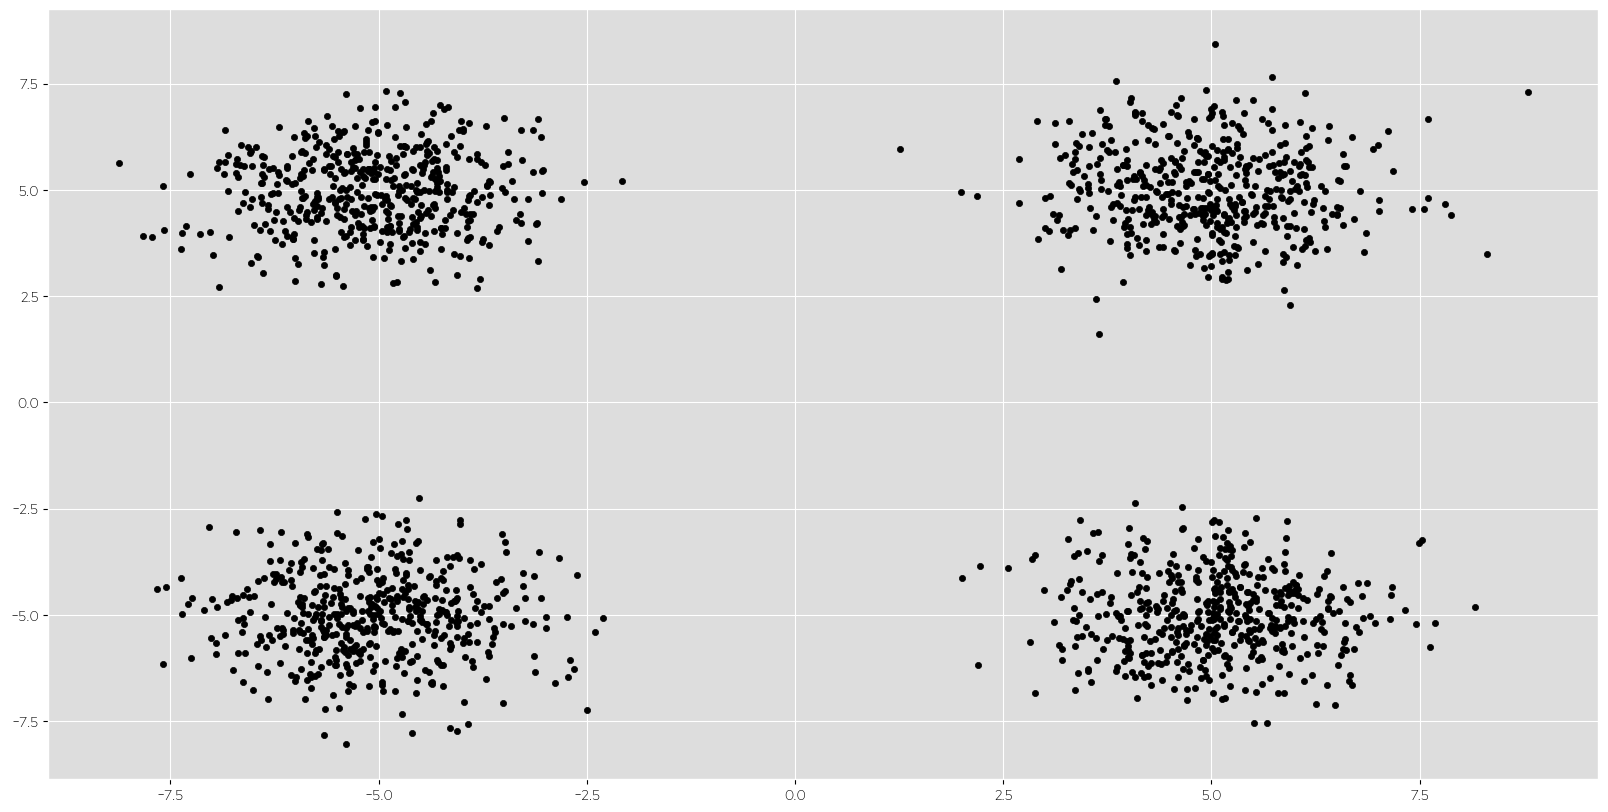

In [2]:
X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(-5,-5), (5, -5),(-5,5), (5, 5)])
plot_clusters(X, y)

Next, we'll fit a K-Nearest Neighbors classifier to this toy dataset, to label each point into a cluster:

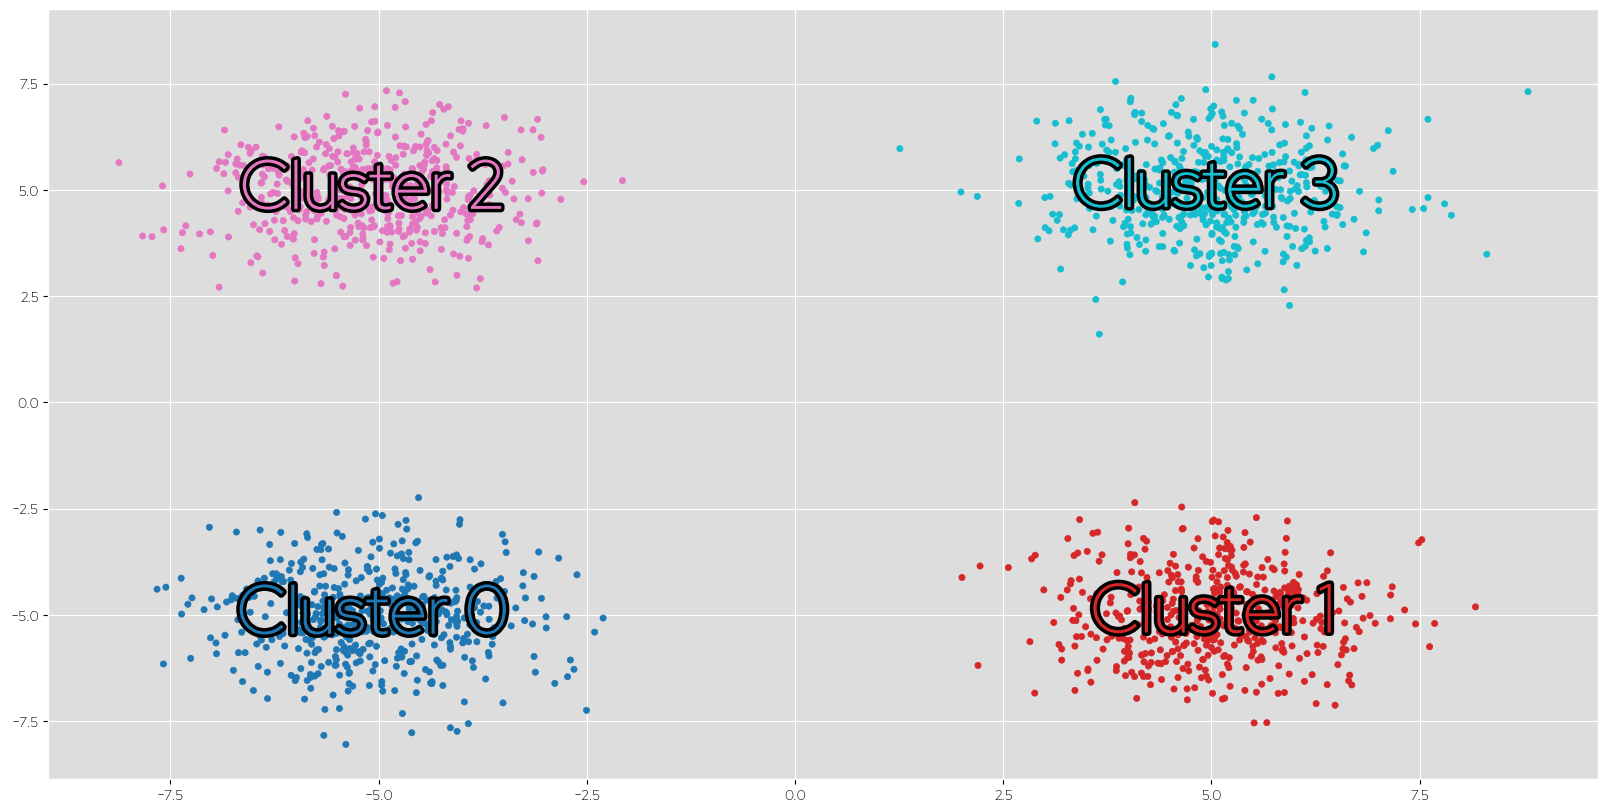

In [4]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X,y)

plot_clusters(X, y, knn)

Looks like our classifier has correctly identified that there are 4 clusters, and the classifications are are spot on. Now let's create a new point, and see where the model places it:

Point P (2.5, -4.0) is classified within cluster 1


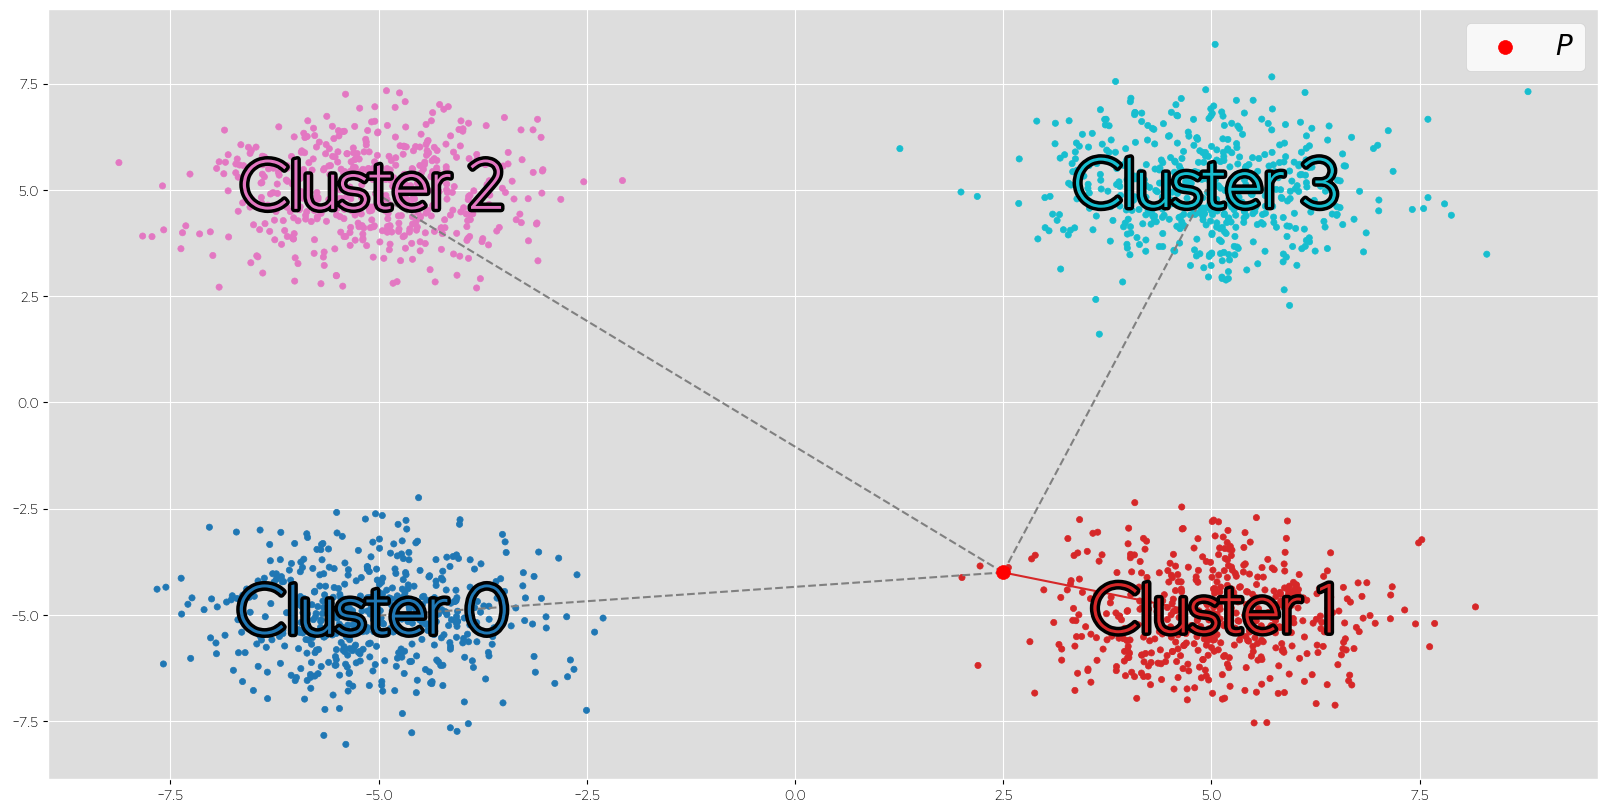

In [5]:
P = np.array([[2.5, -4.0]])

cluster = knn.predict(P)


print(f"Point P ({P[0][0]}, {P[0][1]}) is classified within cluster {cluster[0]}")
plot_clusters(X, y, knn, P)

The new points $P$ is shown in red, and the model has (correctly) placed it into Cluster 1. Lines are drawn to the centroids of each cluster, and we can see that $P$ is closest to Cluster 1 by far.

## Counterfactuals
Say we wanted to find a point nearby to $P$ but with a different classification. We can use a counterfactual explainer to do just that. 

First, we'll wrap our K-Nearest Neighbors classifier into a TrustyAI Model object, which handles all the data transmissions between Java and Python automatically, as well as tracks some attributes about our model:

In [6]:
model = Model(knn.predict, 
              feature_names=["X Position", "Y Position"],
              output_names=['Predicted Cluster'])

Next, we'll initialize the explainer, and define some _feature domains_, that is, reasonable bounds for each feature of the input data. In our case, every points lives within the range $(-10, 10)$, so we'll use that as our x and y feature domains.

In [7]:
counterfactual = CounterfactualExplainer(steps=10_000)
feature_domains = [
    feature_domain((-10, 10)), #x bounds
    feature_domain((-10, 10)), #y bounds
]

Now we can produce a counterfactual explanation, which will give us a nearby point of the desired class. Here, we pass in $P$ as the input point, and specify that our desired goal class is Class 3. This will take a second as the explainer searches for a good solution.

In [8]:
explanation = counterfactual.explain(
    inputs=P,
    goal=3,
    feature_domains=feature_domains,
    model=model)

Let's take a look at what it found:

In [9]:
P_cf = explanation.proposed_features_array
explanation.as_dataframe()

,features,proposed,original,constrained,difference
0,X Position,2.500000,2.5,False,0.000000
1,Y Position,-0.111686,-4.0,False,3.888314


Point P_cf (2.5,-0.1116858311485398) is classified within cluster 3


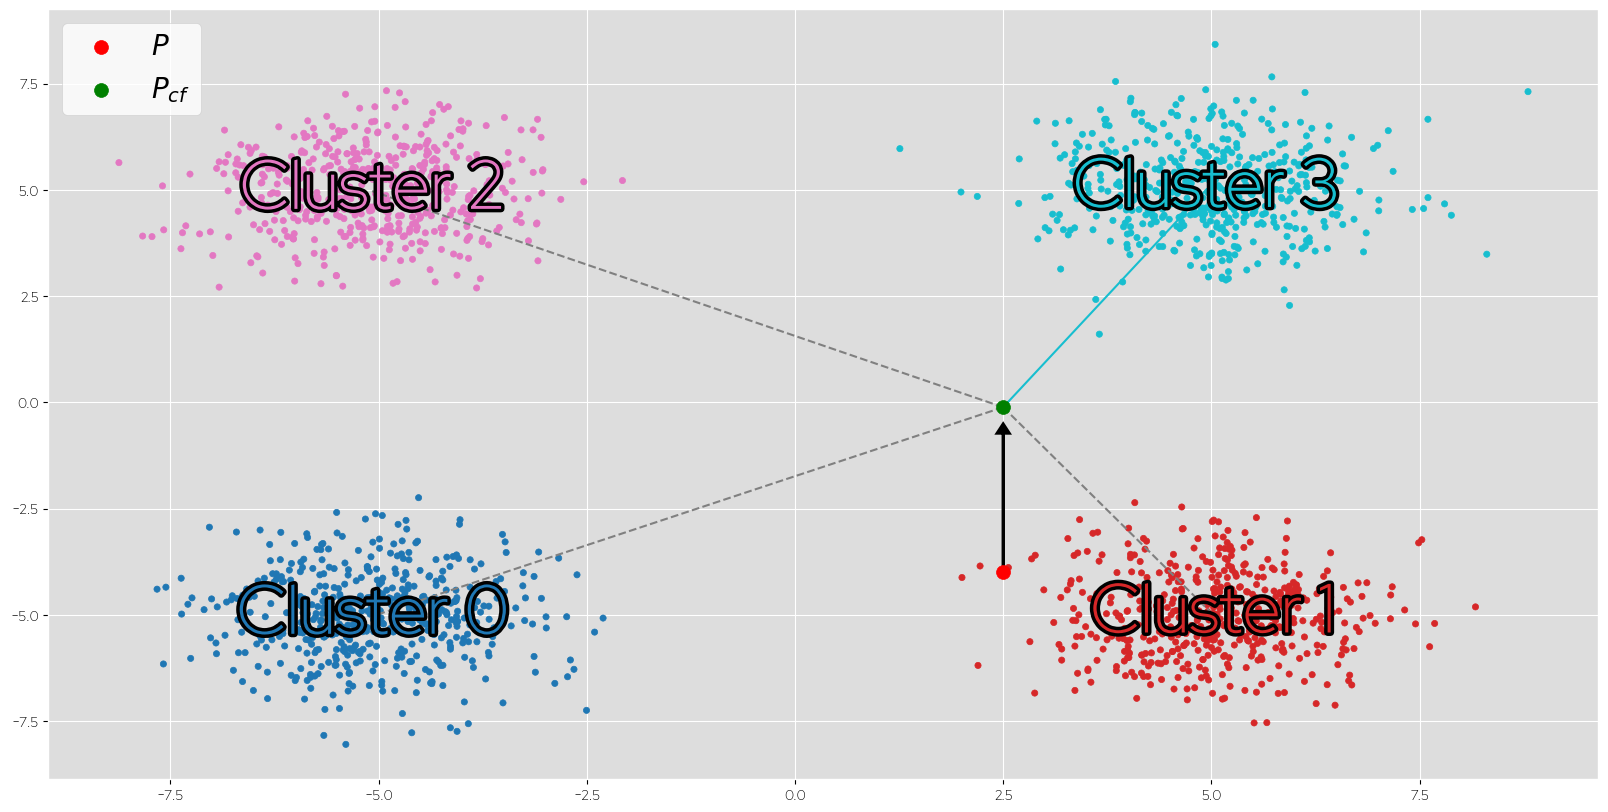

In [10]:
prediction = model(P_cf)
print(f"Point P_cf ({P_cf[0][0]},{P_cf[0][1]}) is classified within cluster {prediction[0]}")
plot_clusters(X, y, knn, P, P_cf)

The new point is indeed in Cluster 3. If we look carefully, we can see that $P_{cf}$ just about as close to $P$ as is possible without becoming classified as Cluster 1; that is exactly the intended purpose of a Counterfactual 
explanation; to create a new datapoint that meets the desired goal while remaining as close to the original as possible.

## LIME
Next, we'll look at a LIME explanation. LIME produces a qualitative description of how important each feature is to the output. Specifically, it looks at how small perturbations of each feature's value affects the model's output, and ranks the feature importances accordingly.

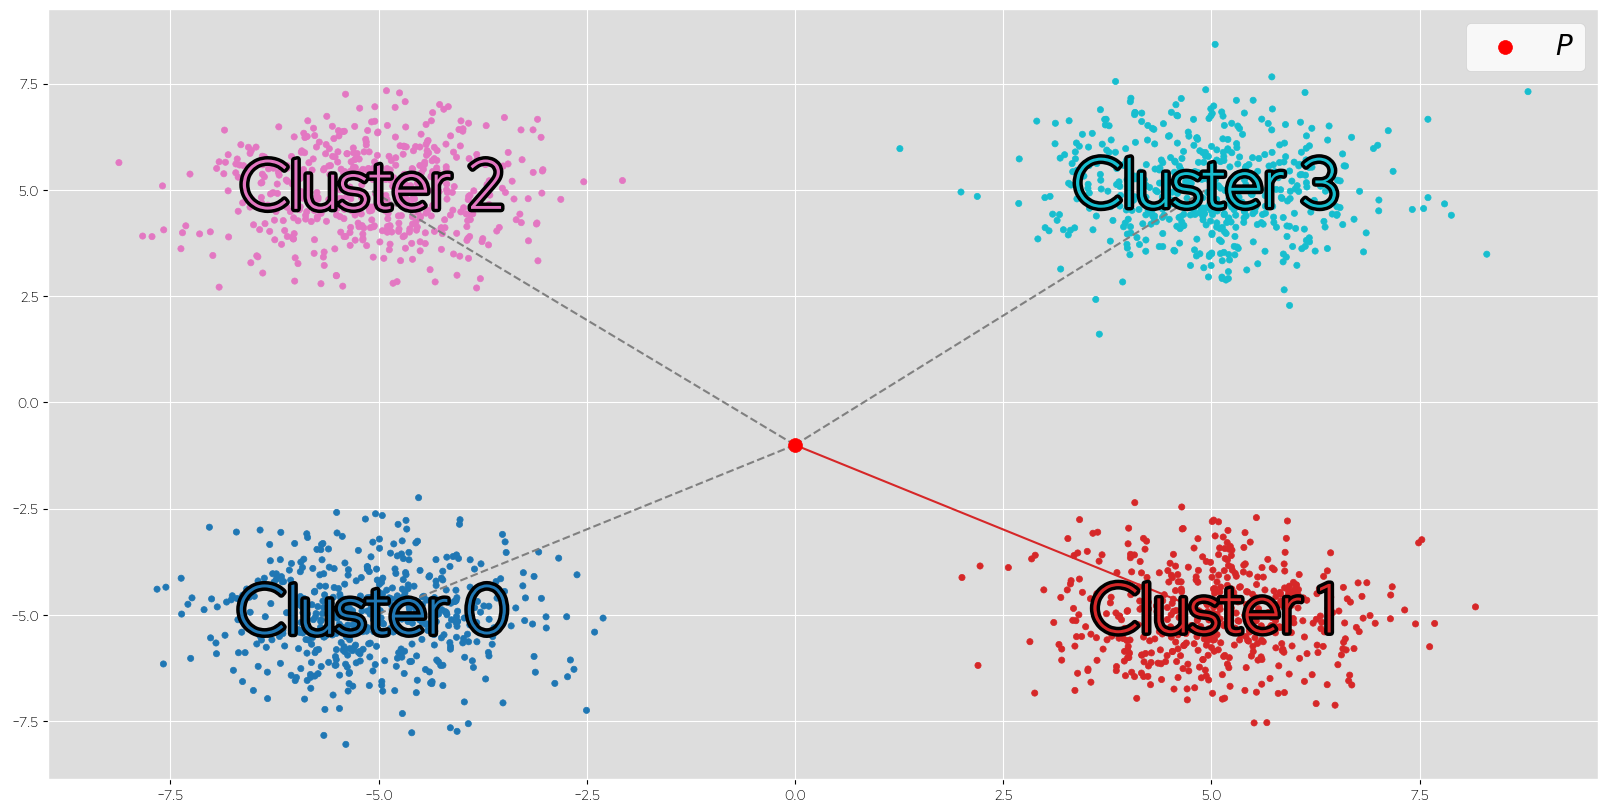

In [11]:
P_lime = np.array([[0., -1.]])

cluster = knn.predict(P_lime)
plot_clusters(X, y, knn, P_lime)

Here, we've chosen a point $P$ right on the boundary between Cluster 0 and Cluster 1. The classifier has chosen Cluster 1, which perhaps has more outlying points closer to $P$ than Cluster 0, but this seems more or less arbitrary. We might expect that any small changes in the x-axis will likely snap the predicted classification to either side of the boundary, while any _small_ movement in the y-axis will be inconsequential. Let's see if LIME agrees:

In [12]:
lime = LimeExplainer(samples=100)

explanation = lime.explain(inputs=P_lime, outputs=prediction, model=model)
explanation.as_dataframe()['Predicted Cluster']

,Feature,Value,Saliency,Confidence
0,X Position,0.0,1.932523,0.0
1,Y Position,-1.0,0.540982,0.0


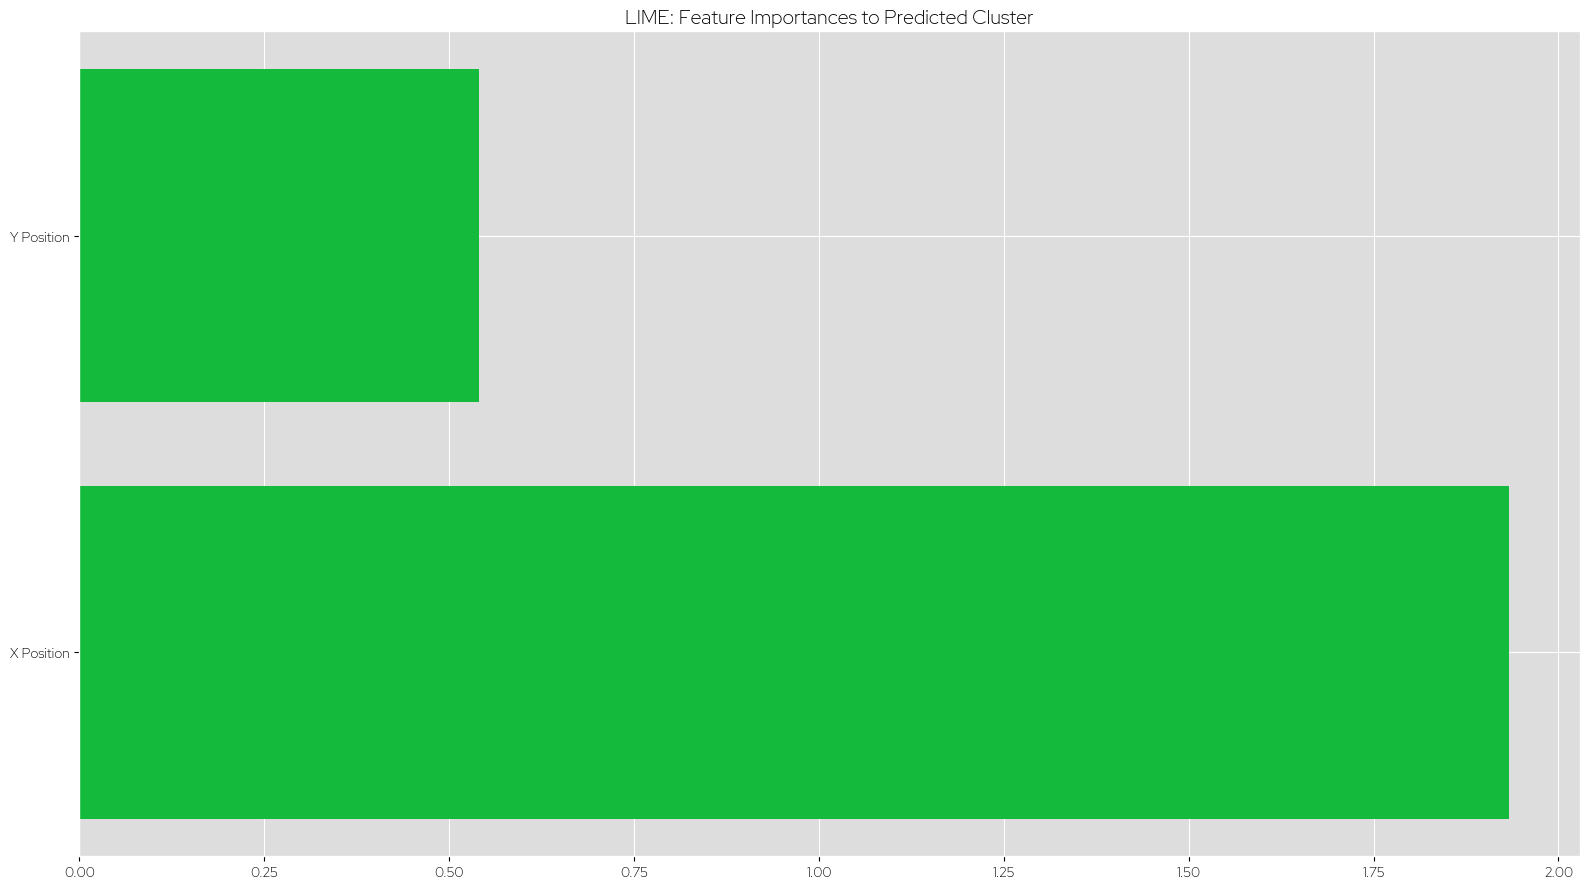

In [13]:
explanation.plot("Predicted Cluster")

LIME agrees with our intuition! A change in the X position is highly influential on the classification, and thus is the most important feature. Meanwhile, small changes in the y-position are less likely to induce classification differences, and thus the y-position is less important.

## SHAP

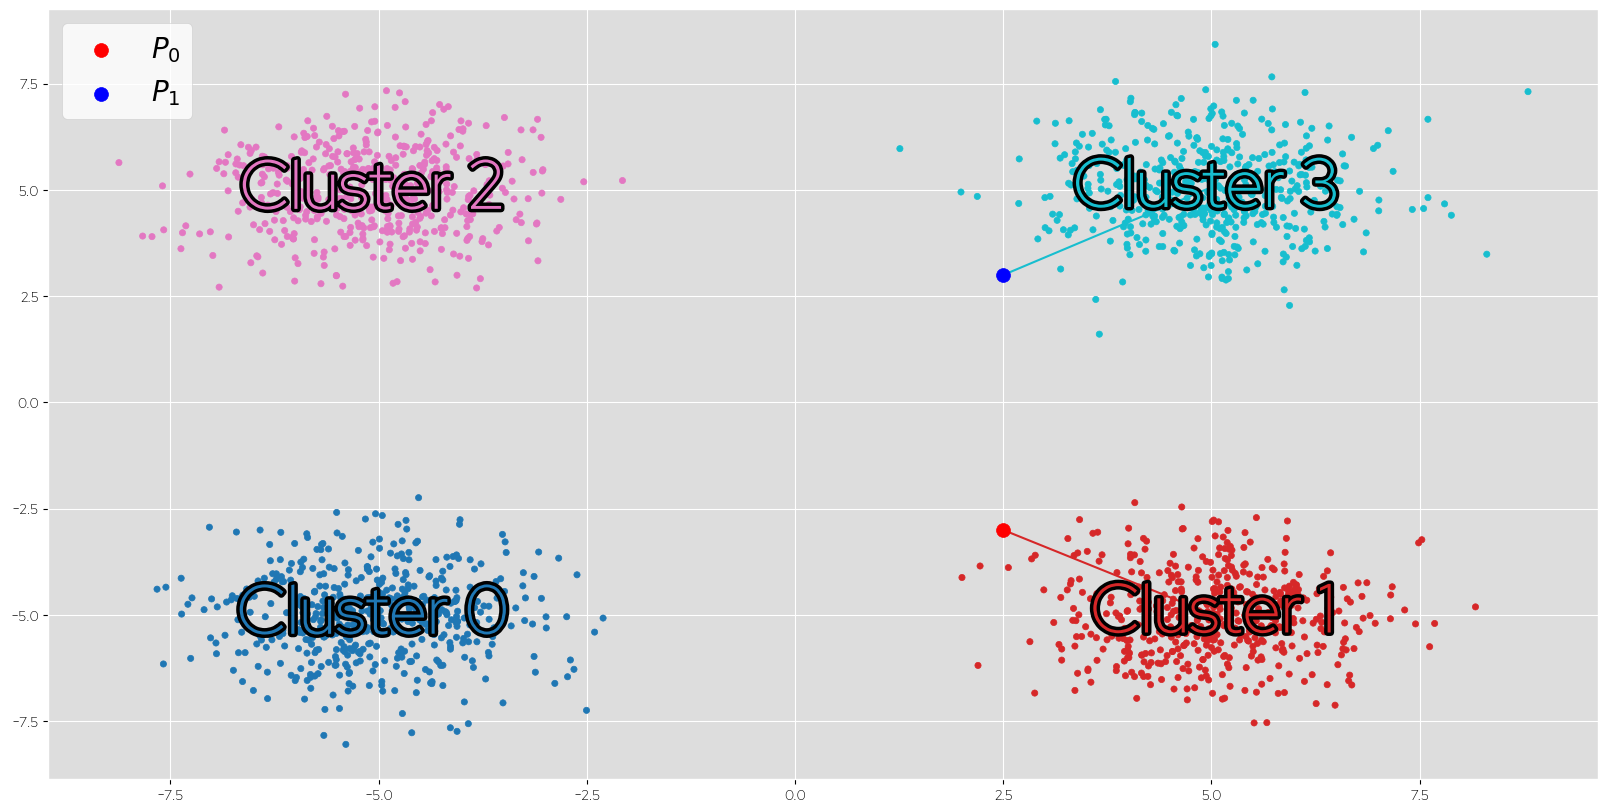

In [14]:
P_shap0 = np.array([[2.5, -3.0]])
P_shap1 = np.array([[2.5, 3.0]])
prediction0 = knn.predict(P_shap0)
prediction1 = knn.predict(P_shap1)
plot_clusters(X, y, knn, [P_shap0, P_shap1])

In [15]:
shap = SHAPExplainer(background=X)
explanation0 = shap.explain(inputs=P_shap0, 
                                 outputs=prediction0,
                                 model=model)
explanation0.as_html()['Predicted Cluster']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,1.500000,nan
1,X Position,2.500000,-0.044372,0.500000,0.000000
2,Y Position,-3.000000,-0.006534,-1.000000,0.000000


In [16]:
explanation1 = shap.explain(inputs=P_shap1, 
                            outputs=prediction1,
                            model=model)
explanation1.as_html()['Predicted Cluster']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,1.500000,nan
1,X Position,2.500000,-0.044372,0.500000,0.000000
2,Y Position,3.000000,-0.006534,1.000000,0.000000


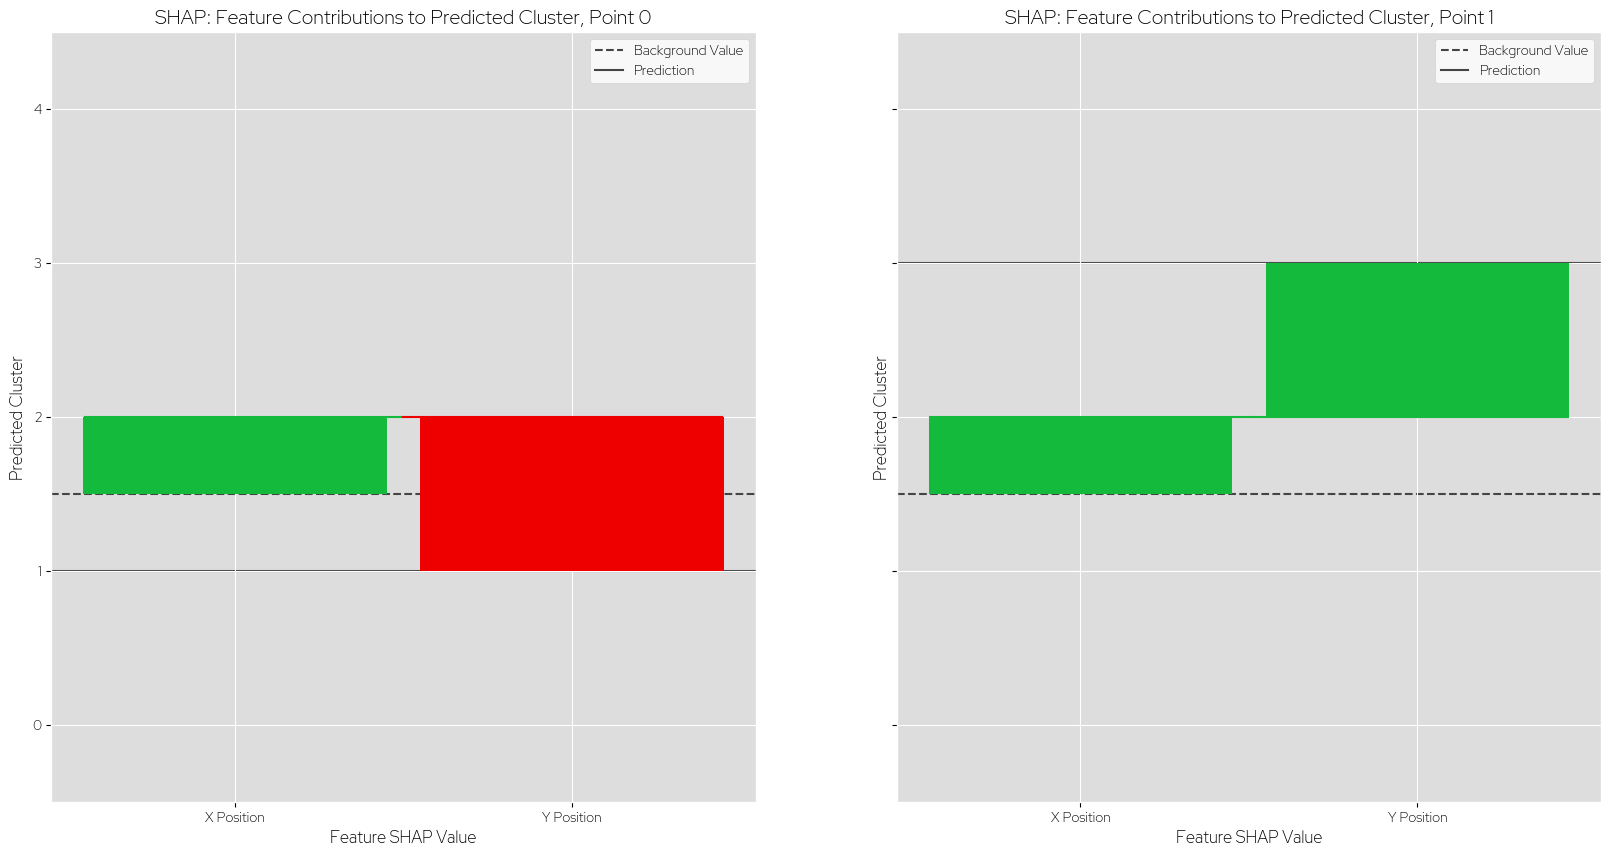

In [17]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(20,10))
plt.axes(axs[0])
plt.ylim(0,4)
explanation0.plot()
plt.title(axs[0].title.get_text() + ", Point 0")

plt.axes(axs[1])
explanation1.plot()
plt.title(axs[1].title.get_text() + ", Point 1")
plt.show()

# Python model

Now let's look at a more real-world application. This data looks at loan applicants, and the model tries to predict whether a particular applicant will default on the loan.

In [18]:
np.random.seed(0)
X_train, X_test, y_train, y_test = get_loan_data()
X_train.iloc[:5]

,# Children,Total Income,# Family Members,Male?,Own Car?,Own Realty?,Partnered?,Working?,Live with Parents?,Days Old,Days Employed
5593,0,157500.0,2.0,0,0,0,1,1,0,12915,3174
3021,0,166500.0,2.0,1,0,1,1,1,0,18926,6276
3053,2,216000.0,4.0,0,0,1,1,1,0,15444,3112
6071,0,292500.0,2.0,0,0,0,1,1,0,20953,8684
1271,0,247500.0,1.0,0,0,1,0,1,0,17016,1347


Let's train an XGBoost Classifier to predict whether an applicant will default:

In [19]:
np.random.seed(0)
xgb_model = xgboost.XGBClassifier()
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
prediction_probs = xgb_model.predict_proba(X_test)


print('Test Accuracy: {:.2f}%'.format(xgb_model.score(X_test, y_test)*100))
cmatrix = sklearn.metrics.confusion_matrix(y_test, predictions)
print("\n  Correctly Predicted Defaulted:", cmatrix[0][0])
print("  Correctly Predicted Payed:    ", cmatrix[1][1])
print("Incorrectly Predicted Defaulted:", cmatrix[1][0])
print("Incorrectly Predicted Payed:    ", cmatrix[0][1])

Test Accuracy: 81.33%

  Correctly Predicted Defaulted: 313
  Correctly Predicted Payed:     262
Incorrectly Predicted Defaulted: 98
Incorrectly Predicted Payed:     34


Our model performs decently well, correctly predicting around 80% of test cases, and nothing in the confusion matrix looks particular concerning. 

Let's grab a random test applicant, and try and figure out how the model is processing that applicant. Let's call her Mrs. Twentyfive:

In [20]:
idx = 25
mrs_25 = X_test.iloc[idx]
mrs_25_prediction = prediction_probs[idx]

print(mrs_25)
if mrs_25_prediction[1]>.5:
    print("\nMrs. Twentyfive is expected ({:.2f}%) to default on the loan.".format(mrs_25_prediction[1]*100))
else:
    print("\nMrs. Twentyfive is expected ({:.2f}%) to pay back the loan on time.".format(mrs_25_prediction[0]*100))

# Children                 0.0
Total Income          270000.0
# Family Members           2.0
Male?                      0.0
Own Car?                   1.0
Own Realty?                1.0
Partnered?                 1.0
Working?                   1.0
Live with Parents?         0.0
Days Old               19861.0
Days Employed          10843.0
Name: 3293, dtype: float64

Mrs. Twentyfive is expected (57.86%) to pay back the loan on time.


## TrustyAI Setup
We start by preparing our model to be used by TrustyAI by wrapping the prediction endpoint, `xgb_model.predict` in the TrustyAI `Model` class.
This `Model` class takes care of all the plumbing required to run explainers on a black-box model.|

In [21]:
trustyai_model = Model(
    xgb_model.predict_proba,
    dataframe_input=True, 
    feature_names=list(X_train), 
    output_names=["On-time","Default"])

## LIME
Let's use Lime to see what was most important to the on-time prediction.

In [22]:
lime = LimeExplainer(samples=100)

lime_explanation = lime.explain(
    inputs=mrs_25,
    outputs=mrs_25_prediction, 
    model=trustyai_model)

lime_explanation.as_dataframe()['On-time']

,Feature,Value,Saliency,Confidence
0,Own Realty?,1.0,0.155946,0.0
1,Days Old,19861.0,0.104665,0.0
2,Total Income,270000.0,0.105682,0.0
3,Days Employed,10843.0,0.103596,0.0
4,# Family Members,2.0,-0.055358,0.0
5,Own Car?,1.0,0.039513,0.0


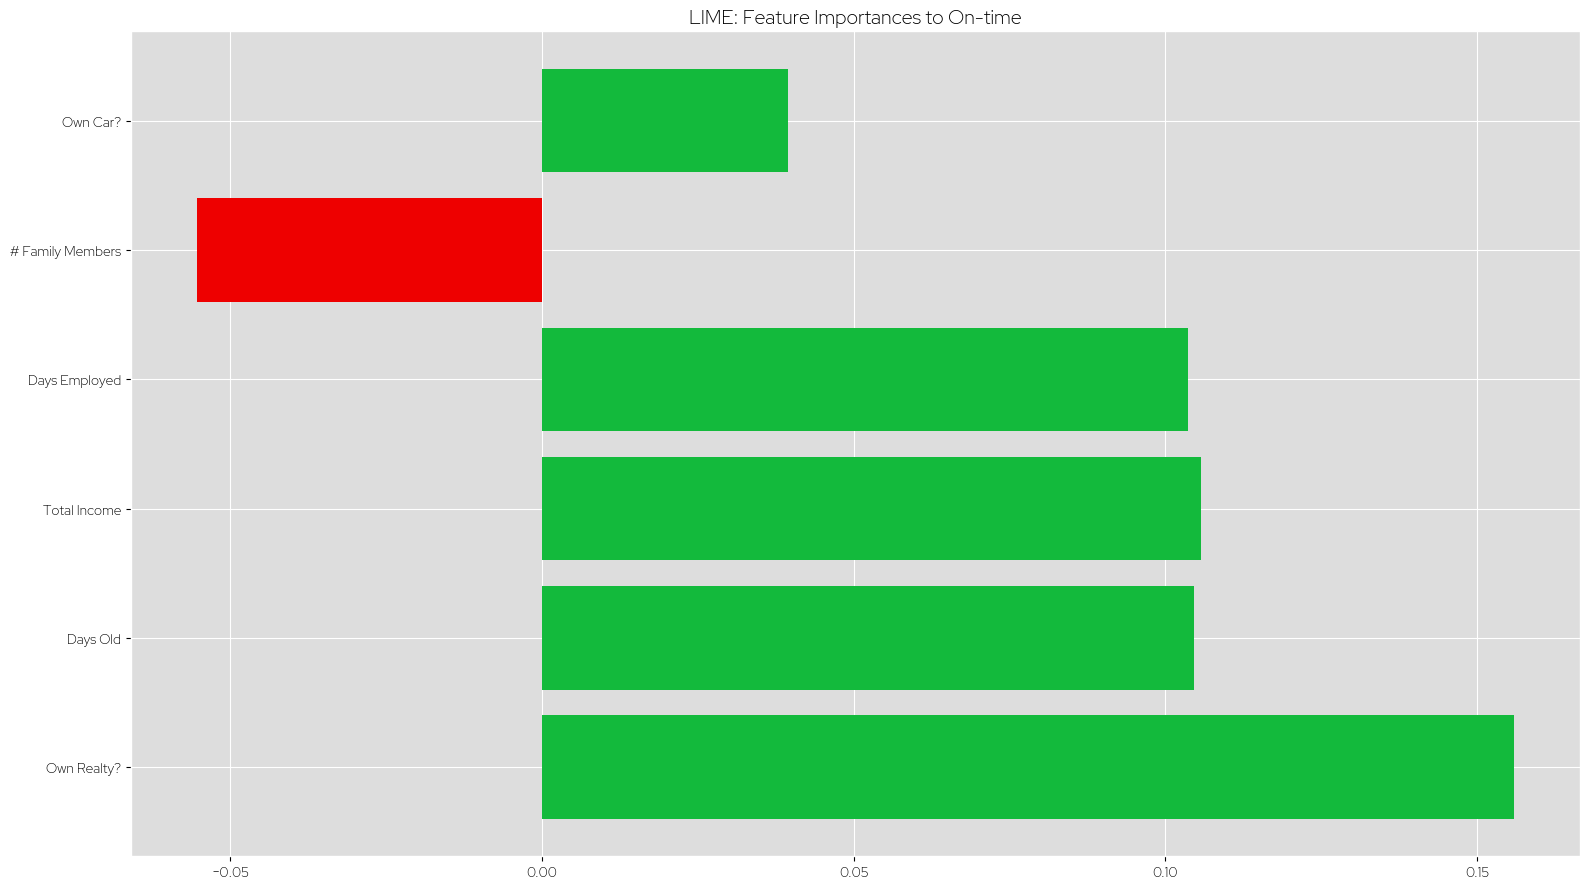

In [23]:
lime_explanation.plot('On-time')

## SHAP
Now, let's use SHAP to get an exact breakdown of how the model got to Mrs. Twentyfive's prediction:

In [24]:
shap = SHAPExplainer(background=X_train[:100])

shap_explanations = shap.explain(inputs=mrs_25, 
                                 outputs=mrs_25_prediction,
                                 model=trustyai_model)

shap_explanations.as_html()['On-time']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,0.545622,nan
1,# Children,0.000000,0.260000,-0.002087,0.013001
2,Total Income,270000.000000,209430.000000,0.072008,0.013001
3,# Family Members,2.000000,2.040000,-0.003538,0.013001
4,Male?,0.000000,0.330000,0.010318,0.013001
5,Own Car?,1.000000,0.380000,0.004689,0.013001
6,Own Realty?,1.000000,0.560000,0.121164,0.013001
7,Partnered?,1.000000,0.780000,-0.003946,0.013001
8,Working?,1.000000,1.000000,0.000000,0.000000
9,Live with Parents?,0.000000,0.090000,-0.003194,0.013001


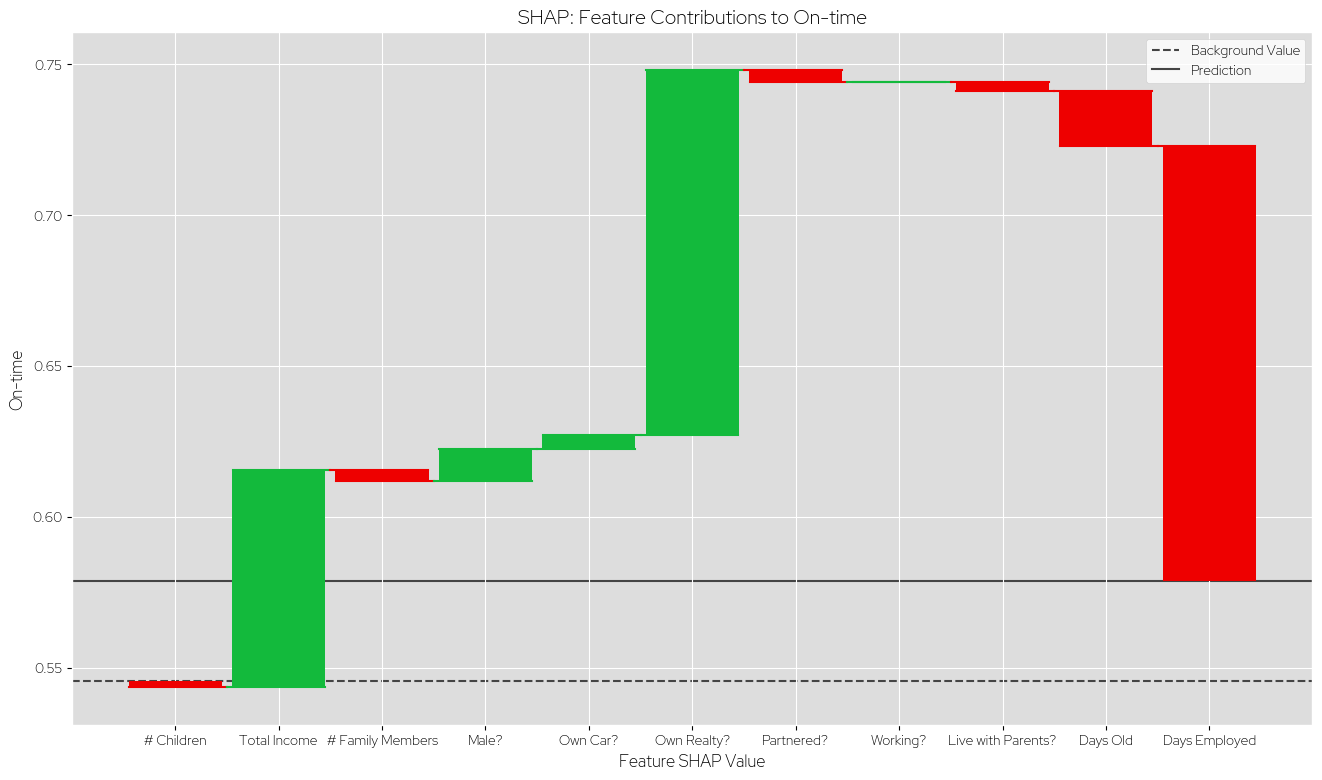

In [25]:
shap_explanations.plot("On-time")

## Counterfactuals
Let's say the bank in question is trying to reduce their risk, and will only give loans out to applicants with a minimum 80% chance of on-time payback. We can use a counterfactual explainer to try and find out how Mrs. Twentyfive can change her application to be accepted for a loan: 

### Unconstrained search
First, let's run an unconstrained search, where every possible change to Mrs. Twentyfive's application is feasible. To do this, we define a very broad set of feature domains for every feature:

In [26]:
feature_domains = []
for col in list(X_train):
    feature_domains.append(
        feature_domain(
            (
                0., # minimum
                float(max(X_train[col]))) #maximum
        )
    )

In [27]:
counterfactual = CounterfactualExplainer(steps=10_000)
goal = .80

cf_explanation = counterfactual.explain(
    inputs=mrs_25,
    goal=np.array([goal, 1-goal]), 
    feature_domains=feature_domains, 
    model=trustyai_model)
cf_explanation.as_html()

,features,proposed,original,constrained,difference
0,# Children,0.000000,0.000000,False,0.000000
1,Total Income,328003.412802,270000.000000,False,58003.412802
2,# Family Members,2.000000,2.000000,False,0.000000
3,Male?,0.000000,0.000000,False,0.000000
4,Own Car?,0.998456,1.000000,False,-0.001544
5,Own Realty?,1.000000,1.000000,False,0.000000
6,Partnered?,1.000000,1.000000,False,0.000000
7,Working?,0.999960,1.000000,False,-0.000040
8,Live with Parents?,0.000000,0.000000,False,0.000000
9,Days Old,21211.755167,19861.000000,False,1350.755167


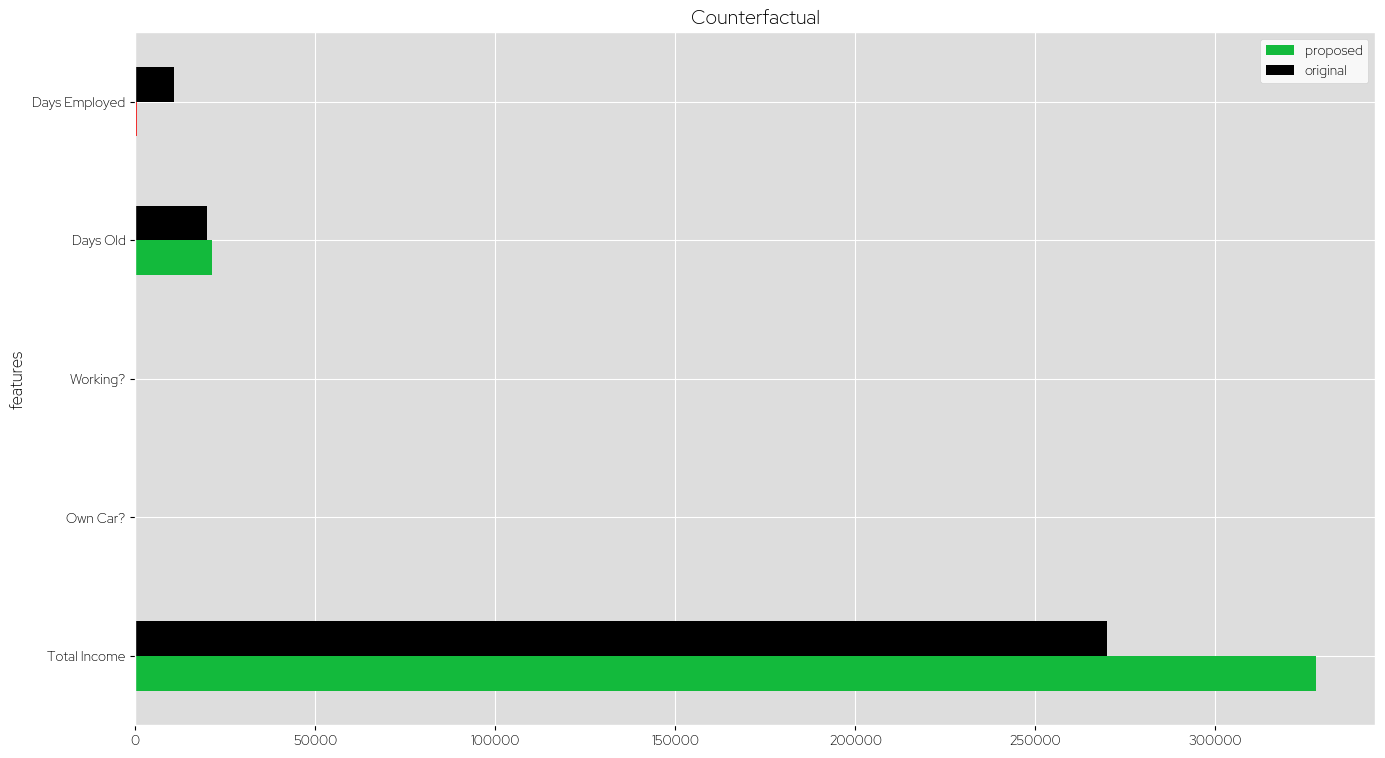

CF Input is predicted at 80.04% on-time payback.


In [28]:
cf_explanation.plot("On-time")
print(
    "CF Input is predicted at {:.2f}% on-time payback.".format(
        trustyai_model(cf_explanation.proposed_features_dataframe)[0][0]*100
    )
)

Notice how the counterfactual suggests reducing her Days Employed from 10,843 to 521, which is not exactly easily possible. Furthermore, it suggests increasing her income by 58k; possible, but difficult. Let's constrain the search to more reasonable ranges:

### Constrained search
To do this, we need to define the valid and feasible ranges for each feature, that is, what Mrs. Twentyfive is willing and able to change about her application. Let's take a look at her current application:

In [29]:
mrs_25

# Children                 0.0
Total Income          270000.0
# Family Members           2.0
Male?                      0.0
Own Car?                   1.0
Own Realty?                1.0
Partnered?                 1.0
Working?                   1.0
Live with Parents?         0.0
Days Old               19861.0
Days Employed          10843.0
Name: 3293, dtype: float64

Now, we'll define some feature domains. Ones that are given as `None` are _fixed_ and the counterfactual search will be unable to change them.

In [ ]:
feature_domains = [
    None, # # Children        
    feature_domain((270_000., 300_000.)),    # Total Income      
    None,    # # Family Members  
    None,    # Male? 
    feature_domain((0., 1.)),    # Own Car?          
    None,    # Own Realty?       
    None,   # Partnered?        
    feature_domain((0., 1.)),    # Working?          
    None,    # Live with Parents?
    feature_domain((mrs_25['Days Old'], mrs_25['Days Old']+5*365)),    # Days Old          
    feature_domain((mrs_25['Days Employed'], mrs_25['Days Employed']+5*365)) # Days Employed     
]

With the new bounds, let's search:

In [31]:
cf_explanation2 = counterfactual.explain(
    inputs=mrs_25,
    goal=np.array([goal, 1-goal]), 
    feature_domains=feature_domains, 
    model=trustyai_model)
cf_explanation2.as_html()

KeyboardInterrupt: 

In [ ]:
cf_explanation2.plot()
print(
    "New CF Input is predicted at {:.2f}% on-time payback.".format(
        trustyai_model(cf_explanation.proposed_features_dataframe)[0][0]*100
    )
)

Now, the counterfactual has found a solution where the only change neccesary is to wait until she's 1,314 days or ~3.6 years older.

# Visualisation

In [32]:
from trustyai.utils.tyrus import Tyrus
tyrus = Tyrus(
    model=trustyai_model,
    inputs=mrs_25,
    outputs=mrs_25_prediction,
    background=X_train[:100]
)

In [33]:
tyrus.run();

# Fairness metrics

In [34]:
nobias = pd.read_csv("data/income-unbiased.zip", index_col=False)

In [35]:
nobias.iloc[:5]

,age,race,gender,income
0,13,0,0,0
1,65,7,0,1
2,71,6,1,0
3,38,1,1,1
4,42,0,0,1


## Demographic Parity


_Demographic Parity_ provides a measure of imbalances in positive and negative outcomes between privileged and unprivileged groups.

Taking the previous data as an example, we would use Demographic Parity metrics to measure if (for instance), the `income` is predicted to be above or below $50k regardless of race or gender.


### Statistical Parity Difference

The _Statistical Parity Difference (SPD)_  is the difference in the probability of prediction between the privileged and unprivileged groups. Typically:

- $SPD=0$ means that the model is behaving fairly in regards of the selected attribute (e.g. race, gender)
- Values between $-0.1<SPD<0.1$ mean that the model is _reasonably fair_ and the score can be attributed to other factors, such as sample size.
- An $SPD$ outside this range would be an indicator of an _unfair_ model relatively to the protected attributes.
    - A *negative* value of statistical parity difference indicates that the unprivileged group is at a disadvantage
    - A *positive* value indicates that the privileged group is at a disadvantage.

The formal definition of $SPD$ is

$$
SPD=p(\hat{y}=1|\mathcal{D}_u)-p(\hat{y}=1|\mathcal{D}_p)
$$

where $\hat{y}=1$ is the favorable outcome and $\mathcal{D}_u$, $\mathcal{D}_p$ are respectively the privileged and unpriviledge group data.


#### Unbiased dataset

In [36]:
nobias.groupby(['gender', 'income'])['income'].count()

gender  income
0       0         1466
        1          548
1       0         5842
        1         2144
Name: income, dtype: int64

<AxesSubplot:xlabel='gender'>

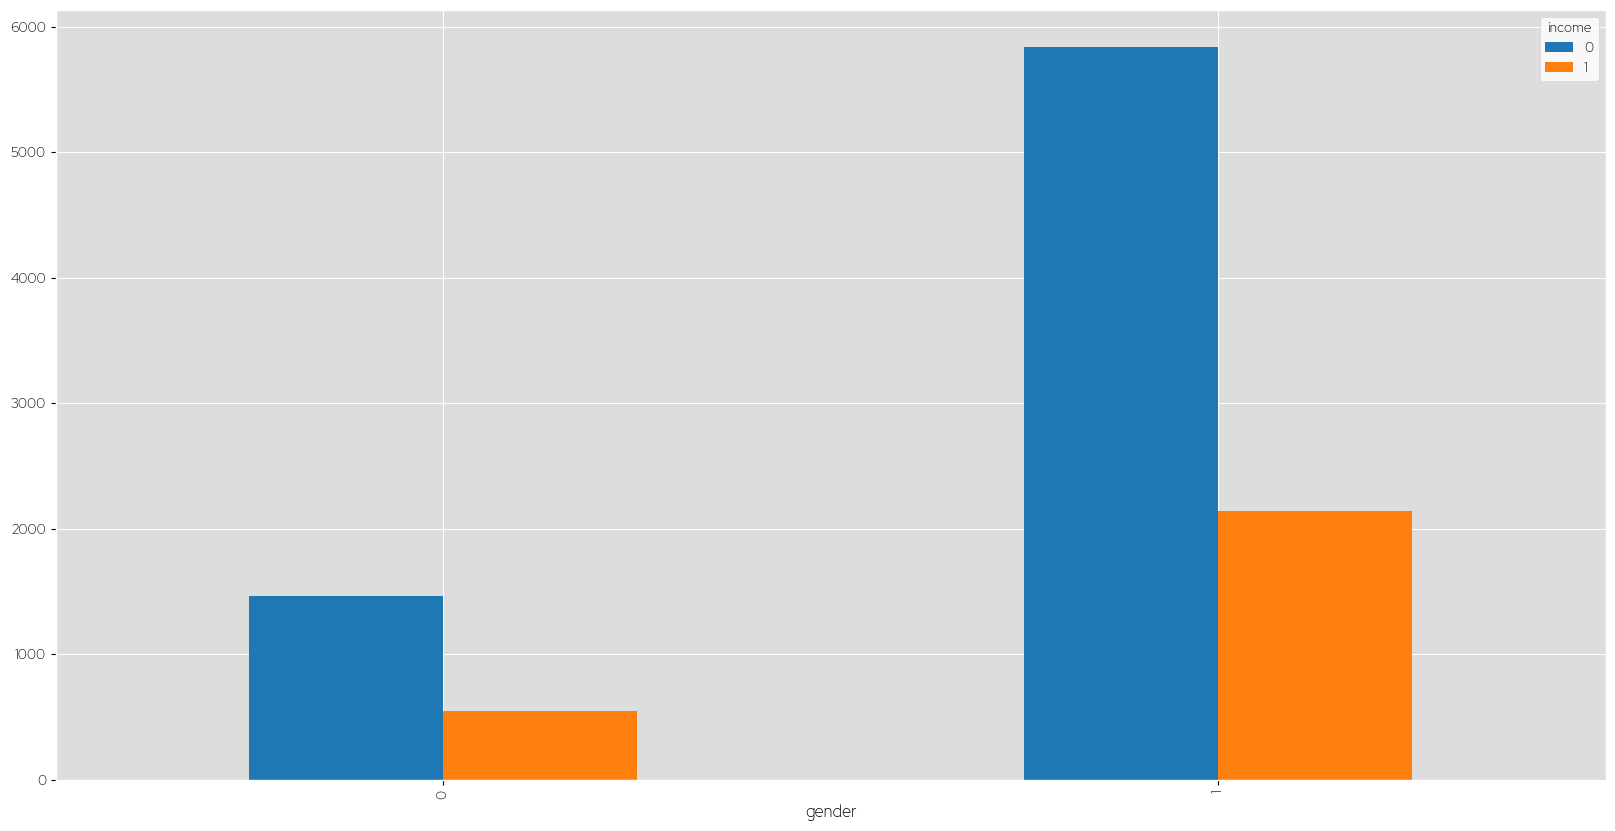

In [37]:
nobias.groupby(['gender', 'income'])['income'].count().unstack().plot.bar(figsize=(20,10))

In [38]:
from trustyai.metrics.fairness.group import statistical_parity_difference, \
    disparate_impact_ratio, average_odds_difference, average_predictive_value_difference

nobias_privileged = nobias[nobias.gender == 1]
nobias_unprivileged = nobias[nobias.gender == 0]
favorable = output("income", dtype="number", value=1)
score = statistical_parity_difference(privileged=nobias_privileged,
                                      unprivileged=nobias_unprivileged,
                                      favorable=[favorable])

In [39]:
print(f"Statistical Parity Difference = {score}")

Statistical Parity Difference = 0.0036255104824703954


We can see that the $SPD$ for this dataset is between the $[-0.1, 0.1]$ threshold, which classifies the model as _reasonably fair_.

#### Biased Dataset

In [40]:
bias = pd.read_csv("data/income-biased.zip", index_col=False)
bias.groupby(['gender', 'income'])['income'].count()

gender  income
0       0         1772
        1          242
1       0         5775
        1         2211
Name: income, dtype: int64

<AxesSubplot:xlabel='gender'>

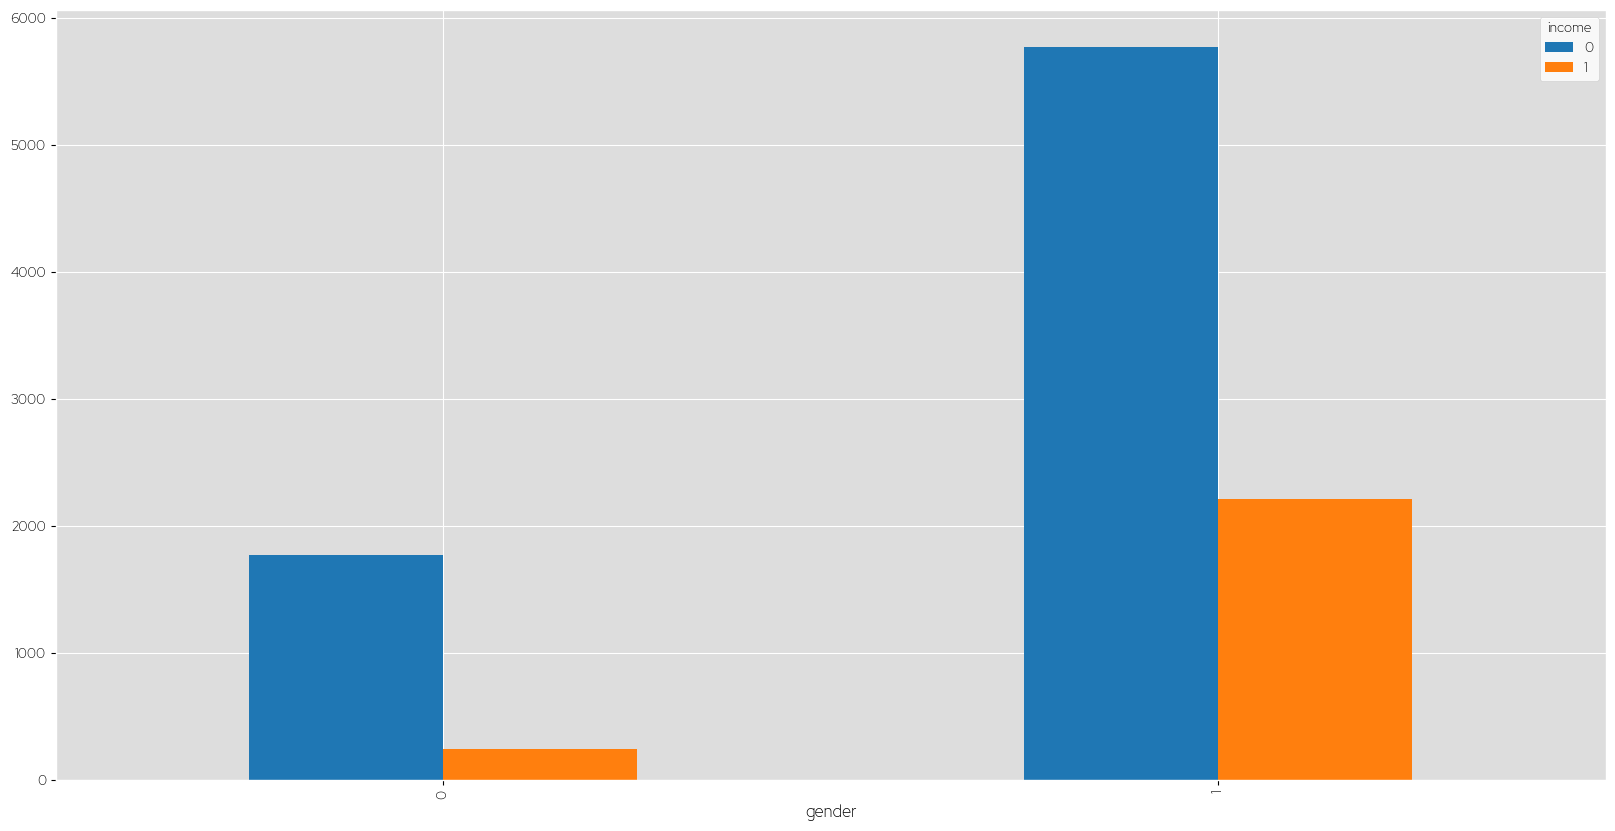

In [41]:
bias.groupby(['gender', 'income'])['income'].count().unstack().plot.bar(figsize=(20,10))

In [42]:
bias_privileged = bias[bias.gender == 1]
bias_unprivileged = bias[bias.gender == 0]

score = statistical_parity_difference(privileged=bias_privileged,
                                      unprivileged=bias_unprivileged,
                                      favorable=[favorable])

In [43]:
print(f"Statistical Parity Difference = {score}")

Statistical Parity Difference = -0.15670061634672994


This dataset, as expected, is outside the $[-0.1, 0.1]$ threshold, which classifies the model as _unfair_.
In addiction, the negative score indicates that the unprivileged group (in our example, `gender = 0`) is the one in disadvantage for this particular outcome.

### Disparate impact ratio


Similarly to the _Statistical Parity Difference_, the _Disparate Impact Ratio (DIR)_ measures imbalances in positive outcome predictions across privliged and unpriviliged groups.
Instead of calculating the difference, this metric calculates the ration of such selection rates.Typically:

- $DIR=1$ means that the model is fair with regards to the protected attribute.
- $0.8<DIR<1.2$ means that the model is _reasonably fair_.

The formal definition of the _Disparate Impact Ratio_ is:

$$
DIR=\dfrac{p(\hat{y}=1|\mathcal{D}_u)}{p(\hat{y}=1|\mathcal{D}_p)}
$$


#### Unbiased

In [44]:
score = disparate_impact_ratio(privileged=nobias_privileged,
                               unprivileged=nobias_unprivileged,
                                      favorable=[favorable])

In [45]:
print(f"Model Disparate Impact Ratio = {score}")

Model Disparate Impact Ratio = 1.0135043501459928


#### Biased

In [46]:
score = disparate_impact_ratio(privileged=bias_privileged,
                               unprivileged=bias_unprivileged,
                                      favorable=[favorable])

In [47]:
print(f"Disparate Impact Ratio = {score}")

Disparate Impact Ratio = 0.43400672901628895


### Average Odds Difference

_Average Odds Difference_ measures the difference between the True Positive Rates ($TPR$) for the privileged and unprivileged groups, and the False Positive Rates ($FPR$) for the same groups. Formally, the definition is:

$$
AOD=\dfrac{(FPR_{u}-FPR_{p})+(TPR_{u}-TPR_{p})}{2}
$$

Typically:

- A fair model will have $AOD=0$
- A positive value indicates the model benefits the unprivileged group
- A negative value indicates the model benefits the privileged group

In [48]:
score = average_odds_difference(test=bias,
                                truth=nobias,
                                privilege_columns=["gender"],
                                privilege_values=[1], # privileged gender value, gender = 1
                                positive_class=[1]) # positive class, income = 1

In [49]:
print(f"Average Odds Difference = {score}")

Average Odds Difference = -0.23806418646688987


As we can see, the $AOD$ indicates that the privileged group (`gender = 1`) is at an advantage in this model.

### Average Predictive Value Difference

The _Average Predictive Value Difference (APVD)_ measures the difference in the average accuracy of predicted values between the privileged and unprivileged groups in a dataset. 

In [50]:
score = average_predictive_value_difference(test=bias,
                                truth=nobias,
                                privilege_columns=["gender"],
                                privilege_values=[1],
                                positive_class=[1])
print(score)

-0.04841289822293428


As we can see, the $APVD$ indicates that predictions over the privileged group (`gender = 1`) receive about 4.8 percentage points higher accuracy from this model.